In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and preprocess the data
data = pd.read_csv('gsw.csv')
data['game_result'] = (data['pts'] > data['opp_pts']).astype(int)
data['game_location'] = data['game_location'].map({'@': 0, 'home': 1})
data['date_game'] = pd.to_datetime(data['date_game'], errors='coerce')
data['year'] = data['date_game'].dt.year
data['month'] = data['date_game'].dt.month
data['day'] = data['date_game'].dt.day
data = data.drop(['date_game', 'opp_pts', 'Team', 'x'], axis=1, errors='ignore')

# Splitting the dataset
X = data.drop('game_result', axis=1)
y = data['game_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining hyperparameters for models
gbc_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
dtc_params = {'max_depth': [None, 10, 20], 'min_samples_split': [5, 10, 20, 30]}

# GridSearchCV for GradientBoostingClassifier
gbc_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gbc_params, cv=3)
gbc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)
gbc_best_params = gbc_grid_search.best_params_

# GridSearchCV for DecisionTreeClassifier
dtc_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dtc_params, cv=3)
dtc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)
dtc_best_params = dtc_grid_search.best_params_

# Defining hyperparameters for RandomForestClassifier
rfc_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# GridSearchCV for RandomForestClassifier
rfc_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rfc_params, cv=3)
rfc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)
rfc_best_params = rfc_grid_search.best_params_

# Preprocessing pipeline
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if col not in categorical_cols + ['game_result']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

# Assembling the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('gbc', GradientBoostingClassifier(**gbc_best_params, random_state=42)),
        ('dtc', DecisionTreeClassifier(**dtc_best_params, random_state=42)),
        ('rfc', RandomForestClassifier(**rfc_best_params, random_state=42))
    ], voting='hard')

# Pipeline for the complex model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_clf)])

# Fitting and predicting with the complex model
pipeline.fit(X_train, y_train)
complex_y_pred = pipeline.predict(X_test)
complex_model_accuracy = accuracy_score(y_test, complex_y_pred)

# Displaying accuracy of the complex model
complex_model_accuracy


0.9371428571428572

In [2]:
from sklearn.linear_model import LogisticRegression

# Training a simpler model - Logistic Regression
simple_model = LogisticRegression(max_iter=1000)
simple_model.fit(X_train.select_dtypes(include='number'), y_train)  # Using only numerical columns

# Predicting with the simpler model
simple_y_pred = simple_model.predict(X_test.select_dtypes(include='number'))

# Calculating accuracy for the simpler model
simple_model_accuracy = accuracy_score(y_test, simple_y_pred)
simple_model_accuracy


/Users/arpanavvari/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9942857142857143

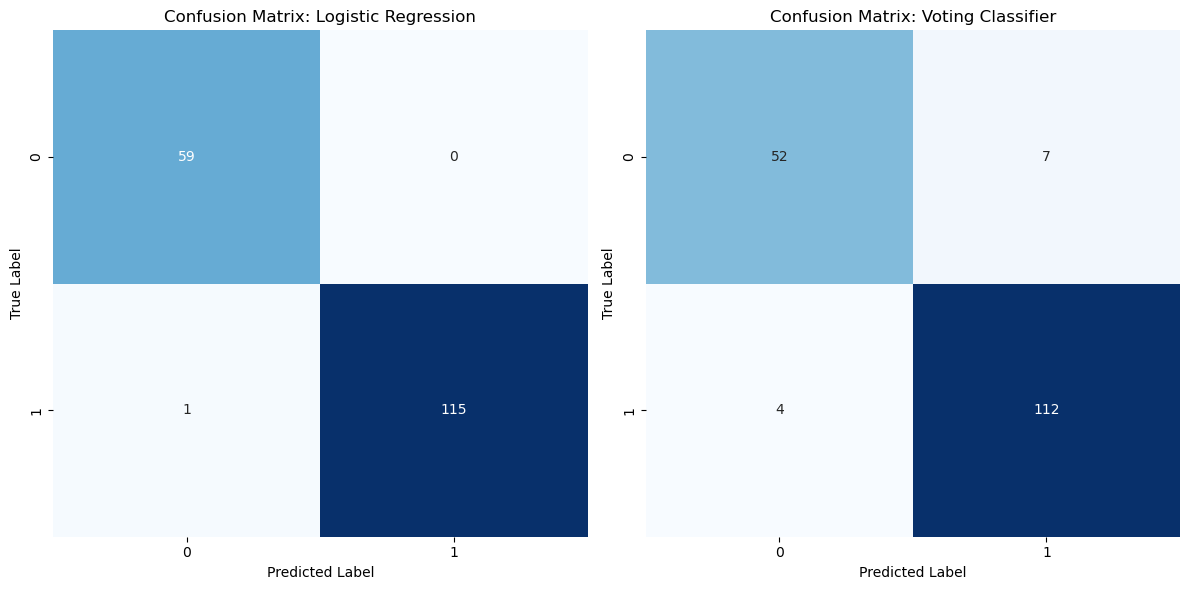

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating confusion matrices for both models
cm_simple = confusion_matrix(y_test, simple_y_pred)
cm_complex = confusion_matrix(y_test, complex_y_pred)

# Plotting the confusion matrices
plt.figure(figsize=(12, 6))

# Simple Model
plt.subplot(1, 2, 1)
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Complex Model
plt.subplot(1, 2, 2)
sns.heatmap(cm_complex, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()



In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming simple_y_pred and complex_y_pred are predictions from simple_model and complex_model
# You've already computed these in your previous code snippets

# Calculate metrics for the simple model
simple_precision = precision_score(y_test, simple_y_pred)
simple_recall = recall_score(y_test, simple_y_pred)
simple_f1 = f1_score(y_test, simple_y_pred)
simple_conf_matrix = confusion_matrix(y_test, simple_y_pred)

# Calculate metrics for the complex model
complex_precision = precision_score(y_test, complex_y_pred)
complex_recall = recall_score(y_test, complex_y_pred)
complex_f1 = f1_score(y_test, complex_y_pred)
complex_conf_matrix = confusion_matrix(y_test, complex_y_pred)

# Output results for the simple model
print("Simple Model Metrics:")
print("Precision:", simple_precision)
print("Recall:", simple_recall)
print("F1-Score:", simple_f1)
print("Confusion Matrix:\n", simple_conf_matrix)
print(classification_report(y_test, simple_y_pred))

# Output results for the complex model
print("\nComplex Model Metrics:")
print("Precision:", complex_precision)
print("Recall:", complex_recall)
print("F1-Score:", complex_f1)
print("Confusion Matrix:\n", complex_conf_matrix)
print(classification_report(y_test, complex_y_pred))


Simple Model Metrics:
Precision: 1.0
Recall: 0.9913793103448276
F1-Score: 0.9956709956709957
Confusion Matrix:
 [[ 59   0]
 [  1 115]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      0.99      1.00       116

    accuracy                           0.99       175
   macro avg       0.99      1.00      0.99       175
weighted avg       0.99      0.99      0.99       175


Complex Model Metrics:
Precision: 0.9411764705882353
Recall: 0.9655172413793104
F1-Score: 0.9531914893617022
Confusion Matrix:
 [[ 52   7]
 [  4 112]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        59
           1       0.94      0.97      0.95       116

    accuracy                           0.94       175
   macro avg       0.93      0.92      0.93       175
weighted avg       0.94      0.94      0.94       175

